Using device: mps

=== PART 1: Architecture Comparison ===
Preparing CIFAR10 data...


100.0%
/Users/divyarao/Documents/sem6/dl/dl lab/.venv/lib/python3.14/site-packages/torchvision/datasets/cifar.py:83: VisibleDeprecationWarning: dtype(): align should be passed as Python or NumPy boolean but got `align=0`. Did you mean to pass a tuple to create a subarray type? (Deprecated NumPy 2.4)
  entry = pickle.load(f, encoding="latin1")


[LeNet5] Epoch 1/5 | Loss: 1.9492 | Train Acc: 27.20% | Test Acc: 33.30%
[LeNet5] Epoch 2/5 | Loss: 1.7648 | Train Acc: 34.10% | Test Acc: 37.99%
[LeNet5] Epoch 3/5 | Loss: 1.6368 | Train Acc: 39.57% | Test Acc: 39.76%
[LeNet5] Epoch 4/5 | Loss: 1.5613 | Train Acc: 42.22% | Test Acc: 43.75%
[LeNet5] Epoch 5/5 | Loss: 1.5067 | Train Acc: 44.59% | Test Acc: 45.83%

=== PART 2 & 3: Loss Functions & Visualization ===
--- Training with Cross Entropy (Standard) ---
[ResNet_CE] Epoch 1/3 | Loss: 1.6052 | Train Acc: 41.25% | Test Acc: 54.60%
[ResNet_CE] Epoch 2/3 | Loss: 1.0513 | Train Acc: 62.38% | Test Acc: 65.46%
[ResNet_CE] Epoch 3/3 | Loss: 0.8333 | Train Acc: 70.44% | Test Acc: 70.14%
Generating t-SNE plot for t-SNE: Cross Entropy Loss...


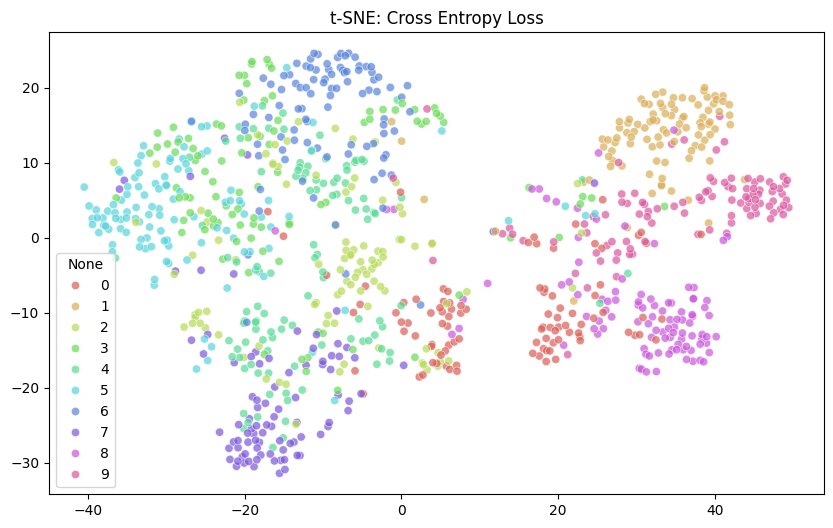

--- Training with Focal Loss ---
[ResNet_Focal] Epoch 1/3 | Loss: 1.1216 | Train Acc: 41.20% | Test Acc: 49.03%
[ResNet_Focal] Epoch 2/3 | Loss: 0.6428 | Train Acc: 61.59% | Test Acc: 64.46%
[ResNet_Focal] Epoch 3/3 | Loss: 0.4856 | Train Acc: 69.86% | Test Acc: 63.20%
Generating t-SNE plot for t-SNE: Focal Loss...


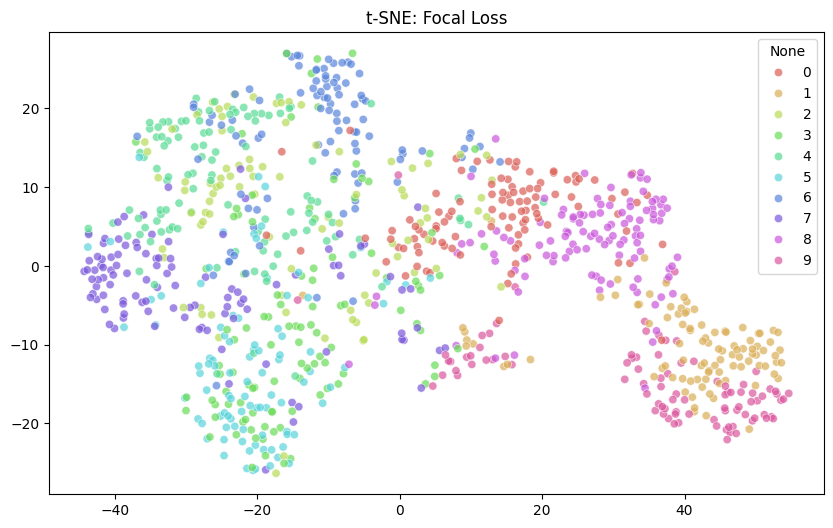

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.models import vgg16, resnet50, resnet101, efficientnet_b0, inception_v3, mobilenet_v2
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math

# --- 1. CONFIGURATION & DEVICE SETUP (Mac M4 Optimization) ---
DEVICE = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {DEVICE}")

BATCH_SIZE = 64 # Reduce if you run out of memory
IMG_SIZE = 224  # Standard size for ImageNet models (VGG, ResNet, etc.)
EPOCHS = 5      # Kept low for demonstration; increase to 10-20 for real results

# --- 2. DATA PREPARATION ---
def get_dataloaders(dataset_name='CIFAR10'):
    print(f"Preparing {dataset_name} data...")
    
    # Models like VGG/ResNet expect 224x224. We resize CIFAR/MNIST.
    transform = transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.Grayscale(num_output_channels=3) if dataset_name == 'MNIST' else transforms.Lambda(lambda x: x),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    if dataset_name == 'CIFAR10':
        trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
        testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
        num_classes = 10
    elif dataset_name == 'MNIST':
        trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
        testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
        num_classes = 10
    
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
    testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False)
    
    return trainloader, testloader, num_classes

# --- 3. MODEL ARCHITECTURES (Part 1) ---

class LeNet5(nn.Module):
    def __init__(self, num_classes=10):
        super(LeNet5, self).__init__()
        self.feature_extractor = nn.Sequential(            
            nn.Conv2d(3, 6, kernel_size=5),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(6, 16, kernel_size=5),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(16, 120, kernel_size=5),
            nn.Tanh()
        )
        self.classifier = nn.Sequential(
            nn.Linear(120, 84),
            nn.Tanh(),
            nn.Linear(84, num_classes),
        )

    def forward(self, x):
        # Handle dynamic input size logic if needed, but for 224x224 input:
        # Note: LeNet is tiny, running it on 224x224 is overkill, but kept for compatibility
        x = F.adaptive_avg_pool2d(self.feature_extractor(x), (1, 1)) 
        x = torch.flatten(x, 1)
        logits = self.classifier(x)
        return logits, x # Return features for t-SNE

# Wrapper to make torchvision models compatible with our loop
class ModelWrapper(nn.Module):
    def __init__(self, model_name, num_classes):
        super(ModelWrapper, self).__init__()
        if model_name == 'alexnet':
            self.model = torchvision.models.alexnet(weights=None)
            self.model.classifier[6] = nn.Linear(4096, num_classes)
        elif model_name == 'vgg':
            self.model = vgg16(weights=None)
            self.model.classifier[6] = nn.Linear(4096, num_classes)
        elif model_name == 'resnet50':
            self.model = resnet50(weights=None)
            self.model.fc = nn.Linear(2048, num_classes)
        elif model_name == 'resnet101':
            self.model = resnet101(weights=None)
            self.model.fc = nn.Linear(2048, num_classes)
        elif model_name == 'efficientnet':
            self.model = efficientnet_b0(weights=None)
            self.model.classifier[1] = nn.Linear(1280, num_classes)
        elif model_name == 'mobilenet':
            self.model = mobilenet_v2(weights=None)
            self.model.classifier[1] = nn.Linear(1280, num_classes)
        elif model_name == 'inception':
             # Inception needs 299x299 usually, we force it to handle our flow or rely on adaptive pool
            self.model = inception_v3(weights=None, aux_logits=True) 
            self.model.fc = nn.Linear(2048, num_classes)
            
    def forward(self, x):
        if hasattr(self.model, 'aux_logits') and self.model.aux_logits:
            if self.training:
                x, _ = self.model(x) # Ignore aux output during train loop
            else:
                x = self.model(x)
        else:
            x = self.model(x)
        return x, x # Returning output twice to match LeNet signature (logits, features)

# --- 4. ADVANCED LOSS FUNCTIONS (Part 2) ---

class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
        return focal_loss.mean()

# ArcFace requires a specific Layer, not just a loss function
class ArcFaceLayer(nn.Module):
    def __init__(self, in_features, out_features, s=30.0, m=0.50):
        super(ArcFaceLayer, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.s = s
        self.m = m
        self.weight = nn.Parameter(torch.FloatTensor(out_features, in_features))
        nn.init.xavier_uniform_(self.weight)

    def forward(self, input, label=None):
        cosine = F.linear(F.normalize(input), F.normalize(self.weight))
        if label is None:
            return cosine * self.s
        
        # Add margin
        theta = torch.acos(torch.clamp(cosine, -1.0 + 1e-7, 1.0 - 1e-7))
        target_logits = torch.cos(theta + self.m)
        
        one_hot = torch.zeros_like(cosine)
        one_hot.scatter_(1, label.view(-1, 1).long(), 1)
        
        output = (one_hot * target_logits) + ((1.0 - one_hot) * cosine)
        output *= self.s
        return output

# --- 5. TRAINING & EVALUATION ENGINE ---

def train_eval(model, train_loader, test_loader, criterion, optimizer, epochs, model_name="Model"):
    train_accs = []
    test_accs = []
    
    # Check if model has ArcFace layer (special handling)
    is_arcface = isinstance(model, ArcFaceLayer) or hasattr(model, 'arcface')

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            
            # Forward pass
            outputs, features = model(inputs)
            
            # Loss calculation
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
        train_acc = 100 * correct / total
        train_accs.append(train_acc)
        
        # Validation
        model.eval()
        test_correct = 0
        test_total = 0
        all_features = []
        all_labels = []
        
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
                outputs, features = model(inputs)
                _, predicted = outputs.max(1)
                test_total += labels.size(0)
                test_correct += predicted.eq(labels).sum().item()
                
                # Collect for t-SNE (only on last epoch)
                if epoch == epochs - 1:
                    all_features.append(features.cpu())
                    all_labels.append(labels.cpu())

        test_acc = 100 * test_correct / test_total
        test_accs.append(test_acc)
        
        print(f"[{model_name}] Epoch {epoch+1}/{epochs} | Loss: {running_loss/len(train_loader):.4f} | Train Acc: {train_acc:.2f}% | Test Acc: {test_acc:.2f}%")

    return train_accs, test_accs, torch.cat(all_features), torch.cat(all_labels)

# --- 6. VISUALIZATION (Part 3) ---

def plot_tsne(features, labels, title="t-SNE"):
    print(f"Generating t-SNE plot for {title}...")
    tsne = TSNE(n_components=2, random_state=42)
    # Take a subset if data is huge to speed up
    subset_idx = np.random.choice(features.shape[0], min(1000, features.shape[0]), replace=False)
    features_subset = features[subset_idx]
    labels_subset = labels[subset_idx]
    
    tsne_results = tsne.fit_transform(features_subset)
    
    plt.figure(figsize=(10, 6))
    sns.scatterplot(
        x=tsne_results[:,0], y=tsne_results[:,1],
        hue=labels_subset, palette=sns.color_palette("hls", 10),
        legend="full", alpha=0.7
    )
    plt.title(title)
    plt.show()

# --- 7. MAIN EXECUTION ---

if __name__ == "__main__":
    # --- Part 1: Architecture Comparison (Example: VGG vs LeNet on CIFAR10) ---
    print("\n=== PART 1: Architecture Comparison ===")
    train_loader, test_loader, num_classes = get_dataloaders('CIFAR10')
    
    # 1. LeNet5
    lenet = LeNet5(num_classes).to(DEVICE)
    opt = optim.Adam(lenet.parameters(), lr=0.001)
    train_eval(lenet, train_loader, test_loader, nn.CrossEntropyLoss(), opt, EPOCHS, "LeNet5")

    # 2. VGG (Example of large model)
    # vgg = ModelWrapper('vgg', num_classes).to(DEVICE)
    # opt = optim.SGD(vgg.parameters(), lr=0.01, momentum=0.9)
    # train_eval(vgg, train_loader, test_loader, nn.CrossEntropyLoss(), opt, EPOCHS, "VGG16")

    # --- Part 2 & 3: Loss Function Study (Example: ResNet with Focal vs BCE) ---
    print("\n=== PART 2 & 3: Loss Functions & Visualization ===")
    
    # Model for experiments
    base_model = ModelWrapper('resnet50', num_classes).to(DEVICE)
    
    # Experiment A: Binary Cross Entropy (Simulated via CrossEntropy for Multiclass)
    print("--- Training with Cross Entropy (Standard) ---")
    optimizer = optim.Adam(base_model.parameters(), lr=0.001)
    _, _, feats_ce, lbls_ce = train_eval(base_model, train_loader, test_loader, nn.CrossEntropyLoss(), optimizer, 3, "ResNet_CE") # Low epochs for speed
    plot_tsne(feats_ce, lbls_ce, "t-SNE: Cross Entropy Loss")

    # Experiment B: Focal Loss
    print("--- Training with Focal Loss ---")
    # Re-init model
    base_model = ModelWrapper('resnet50', num_classes).to(DEVICE) 
    optimizer = optim.Adam(base_model.parameters(), lr=0.001)
    _, _, feats_foc, lbls_foc = train_eval(base_model, train_loader, test_loader, FocalLoss(gamma=2), optimizer, 3, "ResNet_Focal")
    plot_tsne(feats_foc, lbls_foc, "t-SNE: Focal Loss")